In [1]:
import pandas as pd
import os
import io
from IPython.display import display
import cufflinks as cf
cf.go_offline()
import plotly.io as pio
import plotly.graph_objects as go
import requests
from copy import copy
from pathlib import Path
import numpy as np
pio.renderers.default = 'colab'
files = Path('../raw_data/extracted_from_reports/deceased_per_province').glob('*.csv')
df = pd.concat((pd.read_csv(f, parse_dates=['date','report_date']) for f in files))
df['weekday'] = df['date'].dt.weekday
df = df.set_index(['date', 'province', 'weekday'])

In [2]:
df['date_lag'] = ((df['report_date'] - df.index.get_level_values(0)) / pd.Timedelta(days=1)).astype(int)

first_report_date = df['report_date'].min()
first_report = df[df['report_date'] == first_report_date]

MAX_DATE_LAG = 8

grouped_rows = df[df['date_lag'] >= MAX_DATE_LAG].groupby(level=[0,1,2]).max()
grouped_rows['date_lag'] = MAX_DATE_LAG
date_lags = pd.concat([df[df['date_lag'] < MAX_DATE_LAG], grouped_rows])

In [3]:
date_lags = date_lags.join(first_report['value'].rename('first_reported'))
date_lags['first_reported'] = date_lags['first_reported'].fillna(0)
date_lags['value'] -= date_lags['first_reported']

In [4]:
# attempt to estimate delayed reporting based on previously reported for same weekday and province 
def get_estimates_per_province(d):
    for province in d.index.levels[1]:
        for weekday in d.index.levels[2]:
            per_province = d.query('province ==  @province and weekday ==  @weekday')
            for tup in per_province.itertuples():
                date = tup[0][0]
                last_known_val = last_known_col = None
                for col, val in enumerate(tup[1:]):
                    if not np.isnan(val):
                        last_known_val = val
                        last_known_col = col
                        continue
                    v = per_province[[col, last_known_col]].dropna(axis=0).sum().values
                    factor = v[0] / max(5, v[1])
                    estimate = int(round(factor * last_known_val))
        #             print(f"estimate {col} on {date}: factor = {factor:0.4f}. Based on {last_known_val} in {last_known_col}: {estimate}")  
                    yield {'date':date, 'province':province, 'date_lag':col, 'value': estimate}
d = date_lags.pivot_table(index=['date', 'province', 'weekday'], columns=['date_lag'], values='value', aggfunc='sum')
estimated = pd.DataFrame(get_estimates_per_province(d.loc[first_report_date:,:])).pivot_table(index='date', columns='date_lag', values='value', aggfunc='sum')
estimated.iloc[-1,:] = np.nan

In [5]:
# merge estimated into d
d = pd.concat([d.groupby(level=0).sum(), estimated]).groupby('date').sum()

In [6]:
d.loc[:'2020-03-30',:] = d.loc[:'2020-03-30',:].fillna(0)
d[-1] = 0.0
d = d[sorted(d.columns)].diff(axis=1)
d = d.drop(columns=-1).rename(columns={MAX_DATE_LAG:f"{MAX_DATE_LAG} or more"})
estimated = estimated.rename(columns={MAX_DATE_LAG:f"{MAX_DATE_LAG} or more"})

In [7]:
# switcheroo
for col in estimated.columns:
    estimated.loc[estimated[col].dropna().index, col] = d.loc[estimated[col].dropna().index, col]
    d.loc[estimated[col].dropna().index, col] = np.nan

In [8]:
# plot total cases per day, by days lag in reporting

f = d.iplot(title="COVID Deceased Netherlands by reporting lag", 
                            xTitle='date',  barmode='stack', 
                            kind='bar',colorscale='spectral', fill=True, interpolation='hv', 
                            asFigure=True, opacity=1)
f.layout['legend']['title'] = 'report lag<br>(# days later)'
f.layout['xaxis']['tickangle'] = 90
f.layout['xaxis']['dtick'] = 86400000
f.layout['xaxis']['tickformat'] = '%m-%d'
f.layout['bargap'] = 0
f.layout['bargroupgap'] = 0
linewidth = 1
for bar in f.data:
    bar['marker']['line'].update({'width':linewidth})

f.add_trace(go.Bar(
    x=[str(x) for x  in first_report.groupby('date').sum().index], 
    y=[str(y) for y in first_report.groupby('date').sum()['value']],
    orientation= 'v',
    marker= {'color': 'rgba(140, 140, 140, 1)', 'line': {'color': 'rgba(140, 140, 140, 1.0)', 'width': linewidth}},
    name='First report'
    ))

f.data = f.data[-1:] + f.data[:-1]


# add shades for weekends
for w in d.index[d.index.weekday == 5] - pd.Timedelta(days=0.5):
    w = go.layout.Shape(
        x0=str(w), x1=str(w+pd.Timedelta(days=2)), 
        y0=0, y1=1,
        layer='below', 
        yref='paper', xref='x',
        line={'width':0},
        fillcolor='#c6c5c5')
    f.add_shape(w)

In [9]:
traces = [
    go.Bar(
        name = f.data[i+2]['name'] + ' (estimated)',
        marker = copy(f.data[i+2]['marker']).update({'color': f.data[i+2]['marker']['color'].replace(', 1)', ', 0.4)')}),
        x = list(estimated[col].dropna().index),
        y = list(estimated[col].dropna().values),
    ) for i, col in enumerate(estimated.columns)]
f.add_traces(traces)

with open(f.layout['title']['text'] + '.html', 'w') as fid:
    fid.write(f.to_html(include_plotlyjs='cdn'))
f

In [10]:
# needed to save plotly figures as png
!docker run -d --rm -p 9091:9091 quay.io/plotly/orca

2c1f18dd01f5b5061276ca75551c84280cc388b1e344a2499b1d127275fd6b39
docker: Error response from daemon: driver failed programming external connectivity on endpoint wonderful_lewin (c25670ffd572ed5f7f9e095d967677eab17167c6962f6faea80c748007ff9bc5): Bind for 0.0.0.0:9091 failed: port is already allocated.


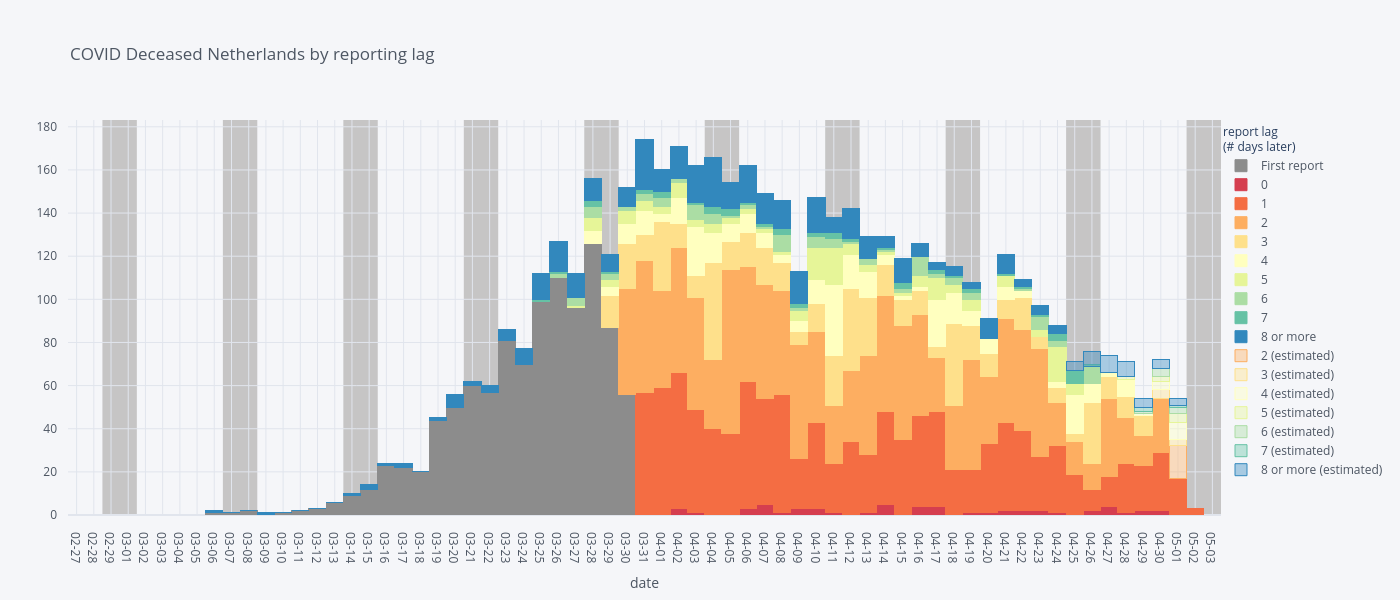

In [11]:
f.update_layout(legend=dict(x=1, y=1),
                margin=dict(
                    l=20,
                    r=120,
                    b=20,
                    t=120,
                    pad=10,
                    ),
                width=1400,
                height=600
                )

res = requests.post('http://localhost:9091', data=f.to_json())
from PIL import Image
im = Image.open(io.BytesIO(res.content))
im.save(f.layout['title']['text'] + '.png')
im